# Getting started with IonSim

## What does IonSim do?

IonSim is built on top of [QuantumOptics.jl](https://qojulia.org/){cite:p}`kramer2018quantumoptics` and is primarily intended to simulate the following general system:

```{figure} media/trapped_ion_system.png
---
width: 700px
name: linear-chain-image
---
A laser shining on a linear chain of trapped ions.
```

or similar systems with different center of mass configurations. In an appropriate rotating frame, the Hamiltonian for the system in [Fig. 1](linear-chain-image) is given by:

$$
\begin{align}
\hat{H} = \sum_{n=1}^N \sum_{m=1}^M \sum_{j_n=1}^{J_n}
\bigg[&\frac{\Omega_{nm}(t)}{2} \sum_{k_n \ne j_n}^{J_n} g(m, k_n, j_n) \hat{\sigma}_{n,k_n,j_n}e^{-i(\bar{\Delta}_{n,m,k_n,j_n}t+\phi_m(t))} e^{i\sum_{l=1}^L \eta_{nml}(t)(\hat{a}_l e^{-i\bar{\nu}_l t} + \hat{a}^{\dagger}_l e^{i\bar{\nu}_l t})} \\
+& \frac{\delta\Delta_{j_n}^B(t)}{2} |j_n\rangle\langle j_n | + \sum_{l=1}^L \frac{\delta\nu_l(t)}{2} \hat{a}^{\dagger}\hat{a}
\bigg] + h.c.
\end{align}
$$ (linear-chain-hamiltonian)

```{dropdown} Variable definitions:
- $\pmb{\Omega_{nm} \cdot g(m, k_n, j_n)}$ describes the coupling between the $m^{th}$ laser and the $n^{th}$ ion's $|k_n\rangle \leftrightarrow | j_n \rangle$ transition (*$\Omega_{nm}$ depends on the intensity of the laser at the ion's position and $g$ is a geometric factor that depends on the details of the laser and transition.*)
- $\pmb{\hat{\sigma}_{n,k_n,j_n}} = |k_n\rangle\langle j_n|$
- $\pmb{\bar{\Delta}_{nmk_nj_n}}$ is the average detuning of the m$^{th}$ laser from $|k_n\rangle \leftrightarrow | j_n \rangle$.
- $\pmb{\phi_m}$ is the initial phase of the $m^{th}$ laser.
- $\pmb{\eta_{nml}}$ is the Lamb-Dicke factor for the particular ion, laser, mode combination.
- $\pmb{\hat{a}_l}$ is the Boson annihilation operator the the $l^{th}$ mode.
- $\pmb{\bar{\nu}_l}$ is the average vibrational frequency for the $l^{th}$ mode.
```

To enable simulation of the above system, IonSim performs two main tasks:
1. Keeps track of the parameters and structure of the Hamiltonian according to user inputs
2. Given these inputs, constructs a function that efficiently returns the numerical representation of the Hamiltonian as a function of time.

The Hamiltonian function can then be used as input to one of the various **QuantumOptics.jl** differential equation solvers.

**1)** is accomplished with the use of Julia [`structs`](https://docs.julialang.org/en/v1/manual/types/). 

For reference, a map of these `structs` and their relationships is shown below.

```{figure} media/graph.png
---
width: 700px
align: center
name: graph
---
Organization of system parameters.
```


**2)** is mainly handled in [hamiltonians.jl](https://github.com/HaeffnerLab/IonSim.jl/blob/master/src/hamiltonians.jl).

## How it works

We'll demonstrate the basics by walking you through some simple examples.

## Load necessary modules

When starting a new notebook, the first thing we have to do is load in the relevant modules.

````{margin}
```{note}
Loading modules can be slow in Julia. The same is true when running a function for the first time. This is often referred to as the *time-to-first-plot problem*, see [here](https://stackoverflow.com/questions/47501844/julia-differentialequations-jl-speed) or [here](https://discourse.julialang.org/t/ways-to-make-slow-sluggish-repl-interactive-development-experience-faster/25293) for more details. One workaround is to just keep notebooks running as long as possible, but you can also look into creating a sysimage with [PackageCompiler.jl](https://github.com/JuliaLang/PackageCompiler.jla).
```
````

In [1]:
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

┌ Info: Precompiling IonSim [511e77fe-ab93-41f7-8f07-8f89809c6435]
└ @ Base loading.jl:1342


In [2]:
using Pkg
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")

   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [511e77fe] ~ IonSim v0.4.2 `~/.julia/dev/IonSim` ⇒ v0.5.0 `~/.julia/dev/IonSim`
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [511e77fe] ~ IonSim v0.4.2 `~/.julia/dev/IonSim` ⇒ v0.5.0 `~/.julia/dev/IonSim`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


We'll also load PyPlot (an interface to Python's matplotlib), which we'll need later

In [3]:
import PyPlot
const plt = PyPlot;

In [4]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

## Defining the system

First we'll create an ion:

In [5]:
ca = Ca40([("S1/2", -1/2), ("D5/2", -1/2)])
print(typeof(ca) <: Ion)

true

In [6]:
print(ca)

⁴⁰Ca
("S1/2", -1//2)
("D5/2", -1//2)


As shown, `Ca40` is a composite type derived from the abstract type `Ion`. We have given the argument `[("S1/2", -1/2), ("D5/2", -1/2)]` to the constructor, which is a vector of tuples. Each element of this vector specifies an electronic state. By specifying the two states `("S1/2", -1/2)` and `("D5/2", -1/2)`, we've decided to include only these two electronic states in the Hilbert space.

To see all of the options for `Ca40` we can look at its doc string, which can be accessed in Julia by typing `?` before the variable name:

In [7]:
?Ca40

search: Ca40



IonInstance(selected_sublevels::Vector{Tuple}[, manualshift::Dict]) Ion instance of some species

`selected_sublevels` specifies which energy sublevels will be present in the Hilbert space of this Ion instance, as a subset of all possible sublevels.

Each element of `selected_sublevels` is a 2-element Tuple `(level::String, sublevels)`, with the first element being the name of a level and the second specifying which sublevels should be included. Allowed sublevels are those whose magnetic quantum number `m` is in the set {`-f`, `-f+1`, `-f+2`, ... `f-1`, `f`}, where `f` is the total angular momentum quantum number of `level`. For each `level` specified there are three allowed options to specify the set of `sublevels` to include:

  * `sublevels::Real`: Includes only one `m = sublevels`
  * `sublevels::Vector{Real}`: Includes all sublevels whose magnetic quantum number `m` is in `sublevels`
  * `sublevels = "all"`: Includes all allowed sublevels

If an element of `selected_sublevels` utilizes the first option, specifying a single `m`, one may optionally may this a 3-element tuple instead: `(level::String, m::Real, alias::String)`, assinging this particular sublevel the alias `alias`.

Omission of a level in `selected_sublevels` will exclude all sublevels.

**Fields**

  * `speciesproperties::IonProperties`: Contains constants specifying parameters specific to species
  * `sublevels`::Vector{Tuple{String,Real}}: List of all sublevels present in the Hilbert space
  * `sublevelaliases::Dict{String,Tuple}`: Dict specifying aliases assigned to sublevels, in the format `alias => sublevel`
  * `shape`::Vector{Int}: Dimension of the Hilbert space
  * `manualshift::OrderedDict`: A dictionary with keys denoting the selected levels and values, a real number for describing a shift of the level's energy. This is just a convenient way to add manual shifts to the simulation, such as Stark shifts off of energy levels not present in the Hilbert space, without additional resources
  * `ionnumber`: When the ion is added to an `IonTrap`, this value keeps track of its order
  * `ionposition`: When the ion is added to an `IonTrap`, this value keeps track of its physical position in meters


````{toggle}
IonInstance(selected_sublevels::Vector{Tuple}[, manualshift::Dict])
Ion instance of species Ca40

`selected_sublevels` specifies which energy sublevels will be present in the Hilbert space of this Ion instance, as a subset of all possible sublevels.

Each element of `selected_sublevels` is a 2-element Tuple `(level::String, sublevels)`, with the first element being the name of a level and the second specifying which sublevels should be included.
Allowed sublevels are those whose magnetic quantum number `m` is in the set {`-f`, `-f+1`, `-f+2`, ... `f-1`, `f`}, where `f` is the total angular momentum quantum number of `level`.
For each `level` specified there are three allowed options to specify the set of `sublevels` to include:
* `sublevels::Real`: Includes only one `m = sublevels`
* `sublevels::Vector{Real}`: Includes all sublevels whose magnetic quantum number `m` is in `sublevels`
* `sublevels = "all"`: Includes all allowed sublevels
If an element of `selected_sublevels` utilizes the first option, specifying a single `m`, one may optionally may this a 3-element tuple instead: `(level::String, m::Real, alias::String)`, assinging this particular sublevel the alias `alias`.

Omission of a level in `selected_sublevels` will exclude all sublevels.

**Fields**
* `speciesproperties::NamedTuple`: Contains constants specifying parameters specific to species
* `sublevels`::Vector{Tuple{String,Real}}: List of all sublevels present in the Hilbert space
* `sublevelaliases::Dict{String,Tuple}`: Dict specifying aliases assigned to sublevels, in the format `alias => sublevel`
* `shape`::Vector{Int}: Dimension of the Hilbert space
* `manualshift::OrderedDict`: A dictionary with keys denoting the selected levels and values, a real number for describing a shift of the level's energy. This is just a convenient way to add manual shifts to the simulation, such as Stark shifts off of energy levels not present in the Hilbert space, without additional resources
* `ionnumber`: When the ion is added to an `IonTrap`, this value keeps track of its order
* `ionposition`: When the ion is added to an `IonTrap`, this value keeps track of its physical position in meters

In IonSim, electronic energy levels are labelled with a string (e.g. `"S1/2"` in `Ca40`), and their magnetic sublevels are labelled with a `Tuple{String, Real}` where the string is the energy level label and the real number is the magnetic quantum number. For example, the `"S1/2"` energy level of `Ca40` has two possible magnetic sublevels, `("S1/2", -1//2)` and `("S1/2", 1//2)`.

Use of these tuples can get cumbersome, so IonSim allows you to assign _aliases_ to sublevels, allowing you to refer to them by any convenient `String`.

This can be done upon instantiation of the `Ion` struct. When specifying a sublevel to include in the Hilbert space, we give the corresponding tuple a third element, which is the `String` specifying the desired alias.

In [8]:
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
print(ca)

⁴⁰Ca
("S1/2", -1//2): "S"
("D5/2", -1//2): "D"


The `print` function now shows us the assigned aliases to each sublevel in the `Ion`'s Hilbert space. These may also be returned with the function `sublevelaliases`:

In [9]:
?sublevelaliases

search: sublevelaliases sublevelalias! sublevelalias clearsublevelalias!



```
sublevelaliases(ion::Ion)
```

Returns a `Dict` specifying all aliases assigned to sublevels of `ion`, in the format `alias => sublevel`, `ion.sublevelalias`


In [10]:
sublevelaliases(ca)

Dict{String, Tuple} with 2 entries:
  "S" => ("S1/2", -1//2)
  "D" => ("D5/2", -1//2)

Next we'll define a `Laser`:

In [11]:
laser = Laser()
print(laser)

λ: missing m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.7071067811865475, z=0.0)
k̂: (x=0, y=0, z=1)
I(t=0): 0 W/m²
ϕ(t=0): 0.0 ⋅ 2π


As shown, the default wavelength of `Laser` is set to `missing`. Typically, one wishes to set a laser wavelength at or near resonance with a particular atomic transition. We will do this later once we have set up the rest of the system.

To include the center of mass motion of the ion in our simulation, we need to add it to an `IonTrap`:

In [12]:
chain = LinearChain(
        ions=[ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )
print(typeof(chain) <: IonTrap)

true

`LinearChain` automatically computes the normal modes for a collection of ions (as input to keyword argument `ions`) in a linear Coloumb crystal with the given center of mass frequencies. By setting `selectedmodes=(;z=[1])` we've decided to only consider the 1st normal mode along the ẑ-direction.

In [13]:
modes(chain)

1-element Vector{VibrationalMode}:
 VibrationalMode(ν=1.0e6, axis=ẑ, N=10)

````{margin}
```{note}
`selectedmodes=(;z=[1])` is the same as `selectedmodes=(x=[], y=[], z=[1])` or `selectedmodes=(y=[], z=[1])`
```
````

````{margin}
```{note}
ẑ is always assumed to be along the crystal's axis of symmetry.
```
````

The last thing we need to construct is a `Chamber`, which collects all of these objects that we've defined.

In [14]:
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[laser]);

A `Chamber` specifically associates an `IonTrap` and a set of lasers. It keeps track of which lasers point at which ions and with how much scaled strength (to model e.g. crosstalk). It also keeps track of the magnetic field. In this case we've set the magnetic field to have a strength of 4 Gauss and to point in the ẑ-direction. δB can be used to model a time-dependent magnetic field, which for example, might be useful to model noise -- for now we set it to 0.

The Hilbert space of a trapped-ion system is made up of a tensor product of the internal electronic states and the states of the vibrational motion. The structs `Ion` and `VibrationalMode` are therefore both Bases, derived from the `Basis` struct in `QuantumOptics.jl`. They are both of the abstract type `IonSimBasis`, which captures all bases in IonSim.

In [15]:
println(IonSimBasis <: Basis)
println(Ion <: IonSimBasis)
println(VibrationalMode <: IonSimBasis)

true
true
true


Since the `Chamber` struct combines Ions with VibrationalModes, it also has a Hilbert space, whose basis is a `CompositeBasis`, a tensor product of its constituent bases:

In [16]:
basis(chamber)

[⁴⁰Ca
 ⊗ VibrationalMode(ν=1.0e6, axis=ẑ, N=10)]

```{note}
Though, mathematically, `Ion ⊗ VibrationalMode` is equivalent to `VibrationalMode ⊗ Ion`, when converted to the space of 2D matrices the description of these two bases will be different. Equivalence is maintained provided that the order is consistent throughout the description of the problem, but this requires us to set a convention. For a trap composed of a linear chain of ions, IonSim's convention is: ion₁ ⊗ ion₂ ⊗ ... ⊗ ionₙ ⊗ mode₁ ⊗ mode₂ ⊗ ... ⊗ modeₙ, where the ion bases are ordered according to the order in `ions(chamber)` and the vibrational modes are ordered according to the order in `[xmodes(chamber), ymodes(chamber), zmodes(chamber)`].
```

## Simulating basic dynamics

### Carrier Rabi oscillations

Let's start off by simulating rabi oscillations between the two considered states of our ion. First we have to update some of the parameters in our system.

First let's set the wavelength of our laser. Here we want to set the wavelength such that the laser is resonant with the `"S" -> "D"` transition in the `Ion` `ca`. This can be done with the function `transitionwavlength` and passing in the arguments `ca` (the ion), `("S", "D")` (the transition), and `chamber` (the Chamber in which `ca` resides). By including `chamber` in our function call, the function `transitionwavlength` takes into account the energy shift due to the magnetic field inside `chamber`.

The function `wavelength!` then sets the laser's wavelength.

````{margin}
```{note}
It's customary in Julia to end the names of functions that update their arguments in-place with a "!".
```
````

In [17]:
λ = transitionwavelength(ca, ("S", "D"), chamber)
wavelength!(laser, λ)

print(wavelength(laser))

7.291469960190796e-7

These two operations can also be done in a single function `wavelength_from_transition!`

In [18]:
wavelength_from_transition!(laser, ca, ("S", "D"), chamber)

7.291469960190796e-7

Due to selection rules and because we've defined our magnetic field to point in the ẑ-direction we need to update the geometry of our laser to have a nonzero coupling to this transition:

In [19]:
polarization!(laser, (x̂ - ẑ)/√2)
wavevector!(laser, (x̂ + ẑ)/√2);

Finally, we should set the laser's intensity (at the position of the ion) to something reasonable. For this we use the convenience function `intensity_from_pitime!`

In [20]:
intensity_from_pitime!(laser, 2e-6, ca, ("S", "D"), chamber);  # Sets pi_time to 2 μs

In [21]:
?intensity_from_pitime

search: intensity_from_pitime intensity_from_pitime!



```
intensity_from_pitime(
    laser::Laser, pi_time::Real, ion::Ion, transition::Tuple,
    Bhat::NamedTuple{(:x,:y,:z)}
)
```

Compute the intensity needed to get a certain `pi_time` with a certain resonant `laser`-`ion` `transition`, in the presence of a magnetic field pointing in the direction `Bhat`.

---

```
intensity_from_pitime(
    laser, pi_time::Real, ion, transition::Tuple, chamber::Chamber
    )
```

Compute the intensity needed to get a certain `pi_time` with a certain resonant `laser`-`ion` `transition` within `chamber`, which defines the magnetic field direction. `laser` may be either a Laser or an Int indicating the desired laser's index within `chamber`. `ion` may be either an Ion or an Int indicating the desired ion's index within `chamber`.


In [22]:
?intensity_from_pitime!

search: intensity_from_pitime! intensity_from_pitime



```
intensity_from_pitime!(
    laser::Laser, pi_time::Real, ion::Ion, transition::Tuple,
    Bhat::NamedTuple{(:x,:y,:z)}
)
intensity_from_pitime!(
    laser, pi_time::Real, ion, transition::Tuple, chamber::Chamber
)
```

Same as `intensity_from_pitime`, but updates `laser[:I]` in-place.


The last thing we need to do before we run our simulation is to construct the hamiltonian:

In [23]:
?hamiltonian

search: hamiltonian



```
hamiltonian(
        chamber::Chamber; timescale::Real=1, lamb_dicke_order::Union{Vector{Int},Int}=1,
        rwa_cutoff::Real=Inf, displacement="truncated", time_dependent_eta=false
    )
```

Constructs the Hamiltonian for `chamber` as a function of time. Return type is a function `h(t::Real, ψ)` that, itself, returns a `QuantumOptics.SparseOperator`.

**args**

  * `timescale`: e.g. a value of 1e-6 will take time to be in $\mu s$
  * `lamb_dicke_order`: Only consider terms that change the phonon number by up to this value.   If this is an `Int`, then the cutoff is applied to all modes. If this is a `Vector{Int}`,   then `lamb_dicke_order[i]` is applied to the iᵗʰ mode, according to the order in   `basis(chamber)`.   Note: this isn't quite the same thing as the Lamb-Dicke approximation since setting   `lamb_dicke_order=1` will retain, for example, terms proportional to $a^\dagger a$.
  * `rwa_cutoff`: drop terms in the Hamiltonian that oscillate faster than this cutoff.
  * `displacement`: This can be either `"truncated"`(default) or `"analytic"`.

    When an atom is irradiated, both the atom's energy and its momentum will generally be  affected. For an atom in a harmonic potential, the exchange of momentum can be modeled as  a displacement operation $D(α=iηe^{-iνt}) = exp[αa^† - α^*a]$, where $η$ is the  Lamb-Dicke parameter, which can be described equivalently as either being proportional to  the square root of the ratio of the recoil frequency with the ground state energy of the  atom's motion or as the ratio of the spread of the ground state wavefunction to the  wavelength of the laser.

    When `"truncated"` is selected, the matrix elements of $D(α)$ are computed by  constructing $α^* a, αa^†$ in a truncated basis (according to the dimension specified in  your model) and then exponentiating their difference. This has the advantage, amongst  other things, of guaranting unitarity.

    If `"analytic"` is selected, then the matrix elements are computed assuming an infinite-  dimensional Hilbert space.

    For small displacements ($η ≪ N$, where $N$ is the dimension of the motion's Hilbert  space), both of these methods will be good approximations.
  * `time_dependent_eta::Bool`: In addition to impacting the vibrational subspace directly, a  change in the trap frequency, $δν$, will also change the Lamb-Dicke parameter. Since  typically $δν≪ν$, this effect will be small $η ≈ η₀(1 + δν/2ν)$ and doesn't warrant  the additional computational resources needed to calculate and update it in time. In this  case, we can set `time_dependent_eta=false` (default), which will set $η(t) = η₀$.


````{toggle}
```
    hamiltonian(
            chamber::Chamber; timescale::Real=1, lamb_dicke_order::Union{Vector{Int},Int}=1,
            rwa_cutoff::Real=Inf, displacement="truncated", time_dependent_eta=false
        )
Constructs the Hamiltonian for `chamber` as a function of time. Return type is a function
`h(t::Real, ψ)` that, itself, returns a `QuantumOptics.SparseOperator`.

**args**
* `timescale`: e.g. a value of 1e-6 will take time to be in ``\\mu s``
* `lamb_dicke_order`: Only consider terms that change the phonon number by up to this value.
    If this is an `Int`, then the cutoff is applied to all modes. If this is a `Vector{Int}`,
    then `lamb_dicke_order[i]` is applied to the iᵗʰ mode, according to the order in
    `basis(chamber)`.
    Note: this isn't quite the same thing as the Lamb-Dicke approximation since setting
    `lamb_dicke_order=1` will retain, for example, terms proportional to ``a^\\dagger a ``.
* `rwa_cutoff`: drop terms in the Hamiltonian that oscillate faster than this cutoff.
* `displacement`: This can be either `"truncated"`(default) or `"analytic"`.

   When an atom is irradiated, both the atom's energy and its momentum will generally be
   affected. For an atom in a harmonic potential, the exchange of momentum can be modeled as
   a displacement operation ``D(α=iηe^{-iνt}) = exp[αa^† - α^*a]``, where ``η`` is the
   Lamb-Dicke parameter, which can be described equivalently as either being proportional to
   the square root of the ratio of the recoil frequency with the ground state energy of the
   atom's motion or as the ratio of the spread of the ground state wavefunction to the
   wavelength of the laser.

   When `"truncated"` is selected, the matrix elements of ``D(α)`` are computed by
   constructing ``α^* a, αa^†`` in a truncated basis (according to the dimension specified in
   your model) and then exponentiating their difference. This has the advantage, amongst
   other things, of guaranting unitarity.

   If `"analytic"` is selected, then the matrix elements are computed assuming an infinite-
   dimensional Hilbert space.

   For small displacements (``η ≪ N``, where ``N`` is the dimension of the motion's Hilbert
   space), both of these methods will be good approximations.
* `time_dependent_eta::Bool`: In addition to impacting the vibrational subspace directly, a
   change in the trap frequency, ``δν``, will also change the Lamb-Dicke parameter. Since
   typically ``δν≪ν``, this effect will be small ``η ≈ η₀(1 + δν/2ν)`` and doesn't warrant
   the additional computational resources needed to calculate and update it in time. In this
   case, we can set `time_dependent_eta=false` (default), which will set ``η(t) = η₀``.
````

````{margin}
```{note}
setting timescale=1e-6 sets the units of time to μs
```
````

In [24]:
h = hamiltonian(chamber, timescale=1e-6);

Finally, we need to construct and initial state of our system. As shown above, the basis is `⁴⁰Ca ⊗ VibrationalMode(ν=1.0e6, axis=ẑ, N=10)`, so we need to construct a state of this form.

For the `Ion`, an electronic eigenstate can be constructed either by indexing with the sublevel, or with the function `ionstate`.

In [25]:
ion = ions(chamber)[1]

ψ0_ion_1 = ion["S"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "S")

print(ψ0_ion_1)

Ket(dim=2)
  basis: ⁴⁰Ca

 1.0 + 0.0im
 0.0 + 0.0im

In [26]:
ψ0_ion_1 == ψ0_ion_2 == ψ0_ion_3

true

For the `VibrationalMode`, a Fock state can be constructed either by indexing or by the function `fockstate`. In the special case of the ground state, one may use the function `groundstate`.

In [27]:
mode = modes(chamber)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)

Ket(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [28]:
ψ0_mode_1 == ψ0_mode_2 == ψ0_mode_3

true

We can create a ket for the composite system with the tensor operator ⊗ (\otimes)

In [29]:
ψ0 = ion["S"] ⊗ mode[0];

Now we can take `h` and feed it into one of the [`QuantumOptics.timeevolution`](https://qojulia.org/documentation/timeevolution/timeevolution/) solvers:

In [30]:
tspan = 0:0.01:10
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h);

110.800816 seconds (40.09 M allocations: 3.051 GiB, 7.43% gc time)


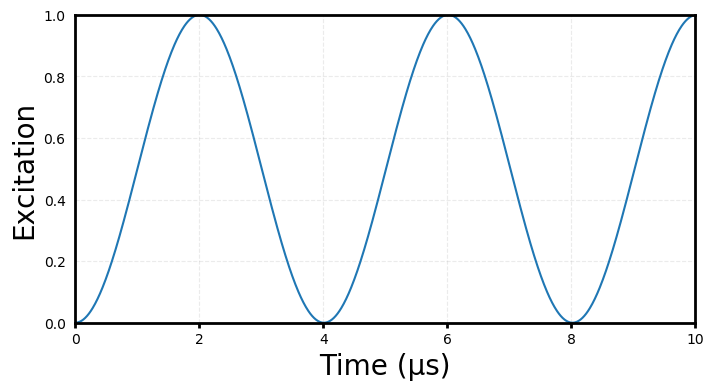

/home/neil/miniconda3/envs/sims/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Palatino'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Palatino'] not found. Falling back to DejaVu Sans.


In [31]:
ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In the above plot, we see Rabi oscillations with a pi-time of 2 μs, as expected.

Now if we add a detuning to the laser equal to the Rabi frequency, we should see oscillation with half the amplitude and √2 times the frequency:

  0.031658 seconds (81.04 k allocations: 2.601 MiB)


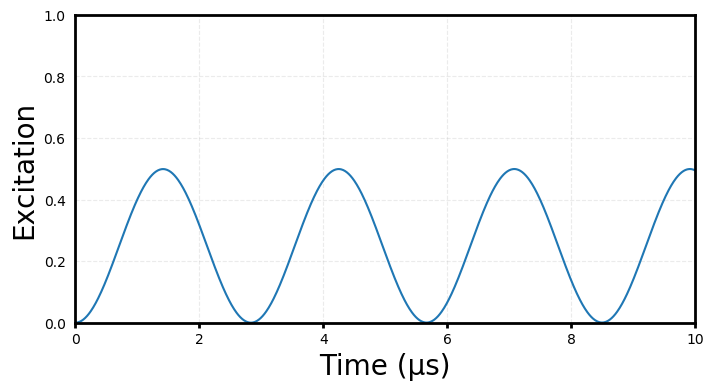

In [32]:
detuning!(laser, 2.5e5)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

We can achieve the same effect by instead setting a nonzero value in our ion's `manualshift` field. This can be useful when we have several ions in our chain and want to simulate some energy shift, for example an AC Stark shift, without involving an additional laser resource.

  0.031258 seconds (95.15 k allocations: 2.970 MiB)


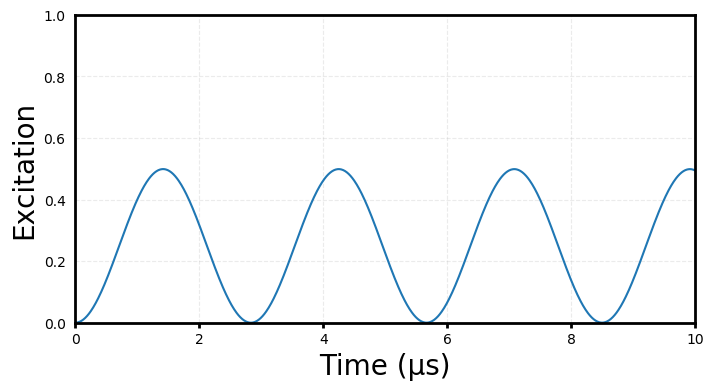

In [33]:
detuning!(laser, 9)

manualshift!(ca, "S", -1.25e5)
manualshift!(ca, "D", 1.25e5)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

So far our simulations have used an initial state `ionstate(ca, "S") ⊗ fockstate(mode, 0)`, or $|S, n=0\rangle$, but we can also start off with the vibrational mode in a thermal state.

Let's start by increasing the dimensionality of the `VibrationalMode` by changing the maximum `N` from 10 to 100.

In [34]:
modecutoff(mode)

10

In [35]:
modecutoff!(mode, 100)
modecutoff(mode)

100

````{margin}
```{note}
`dm(ca["S"])` is the same as `ca["S"] ⊗ ca["S"]'` and corresponds to
$|S⟩⟨S|$.
```
````

In [36]:
# reset all manual shifts to zero
zeromanualshift!(ca)

# create initial state in terms of denisty matrices
ψi_ion = dm(ca["S"]) 
ψi_mode = thermalstate(mode, 10)
ψi = ψi_ion ⊗ ψi_mode

tspan = 0:0.1:50
h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=Inf, time_dependent_eta=false, displacement="truncated")
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

 96.818914 seconds (26.84 M allocations: 2.286 GiB, 1.63% gc time, 22.27% compilation time)


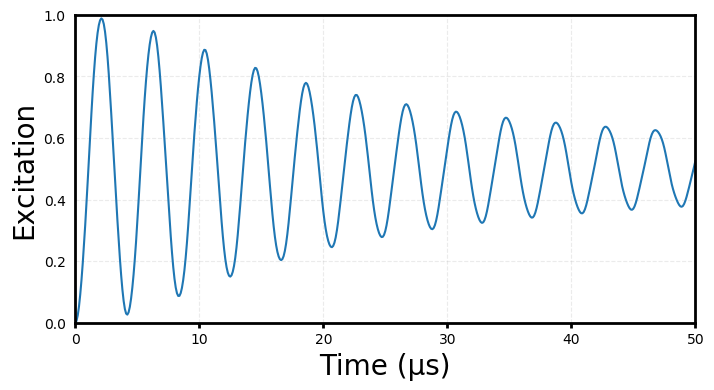

In [37]:
ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

We can compare this result with the analytical expression which can be found in IonSim's `analytical` module:

In [38]:
?analytical.rabiflop

```
rabiflop(tspan, Ω::Real, η::Real, n̄::Real; s::Int=0) <br>
```

Single ion rabi flop. Returns: $\sum_{n=0}^∞ p_n sin^2(\Omega_n t)$ <br> with $\Omega_n = Ωe^{-η^2/2}η^s\sqrt{\frac{n!}{(n+s)!}}L_{n}^{s}(η^2)$ <br> where $s$ is the order of the (blue) sideband that we are driving and $L_{n}^{s}$ is the associated Laguerre polynomial. [ref](https://doi.org/10.1103/RevModPhys.75.281)


````{toggle}
```rabiflop(tspan, Ω::Real, η::Real, n̄::Real; s::Int=0)```

Single ion rabi flop. Returns:
$$
\sum_{n=0}^∞ p_n sin^2(\Omega_n t)
$$
with
$$
\Omega_n = Ωe^{-η^2/2}η^s\sqrt{\frac{n!}{(n+s)!}}L_{n}^{s}(η^2)
$$
where ``s`` is the order of the (blue) sideband that we are driving and $L_{n}^{s}$ is the
associated Laguerre polynomial. [ref](https://doi.org/10.1103/RevModPhys.75.281)
````

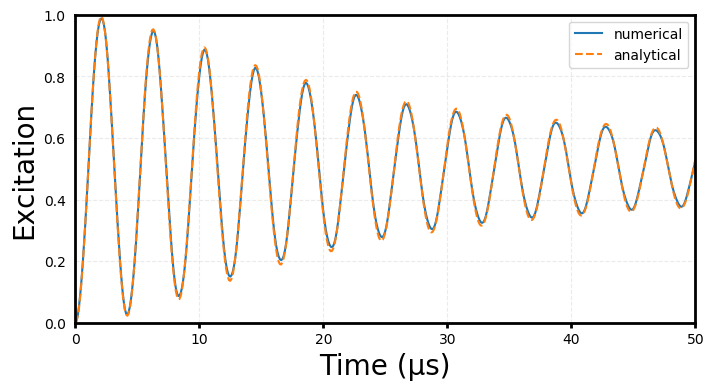

In [39]:
ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex, label="numerical")

η = lambdicke(mode, ca, laser)
plt.plot(
        tout, analytical.rabiflop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical"
    )

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

We see good, but not perfect agreement between the two curves. In fact, the majority of this discrepancy comes from off-resonant interaction with the first order sideband which the simulation captures but the analytical solution does not.

This can be confirmed by eliminating this off-resonant interaction in our simulation by setting they keyword argument `lamb_dicke_order` in the `hamiltonian` function to zero (by default, this is set to 1).

In [40]:
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=0)  # set lamb_dicke_order here
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

114.648591 seconds (722.29 k allocations: 342.144 MiB, 0.66% gc time, 0.01% compilation time)


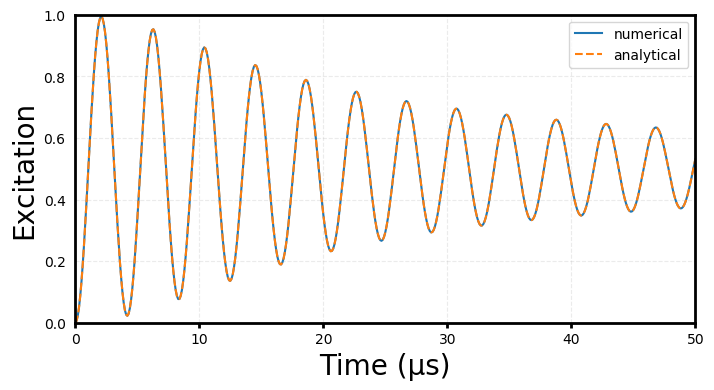

In [41]:
ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex, label="numerical")

η = lambdicke(mode, ca, laser)
plt.plot(
        tout, analytical.rabiflop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical"
    )

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

Which gives a much better agreement between the two curves.

At this point, it's worth explaining in more detail what we've just done. Conventionally, we would probably guess that setting the `lamb_dicke_order` to `n` would be equivalent to truncating the Taylor series expansion of the displacement operator $D(iη e^{iνt})$ after the $n^{th}$ order in η.

But this is not what IonSim does. Instead, it just drops all (Fock basis) matrix elements of $\langle m | D | n \rangle$ where $|m-n| > n$. 

All matrix elements of the operator are computed [analytically](https://doi.org/10.1103/PhysRev.177.1857). So, for example, even if we set `lamb_dicke_order=0`, we'll still retain the precise effect that the mode coupling has on the carrier transition -- as in the above example. 

### Sideband Transitions

Let's see some examples of driving sideband transitions:

  3.933590 seconds (1.14 M allocations: 30.194 MiB)
  0.220690 seconds (1.23 M allocations: 32.709 MiB)


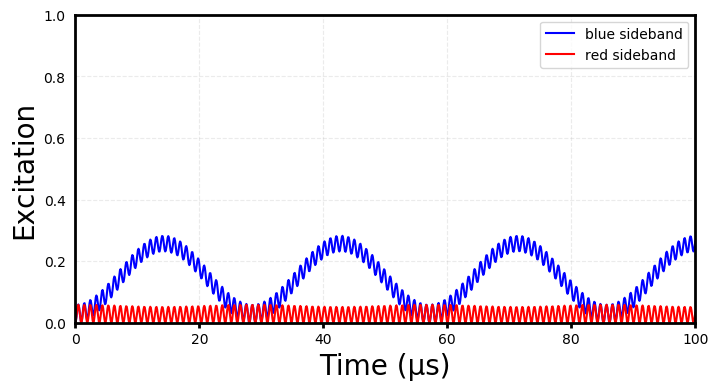

In [42]:
tspan = 0:0.1:100
# set the motional dimension back to 10
modecutoff!(mode, 10)

# tune laser frequency to blue sideband
ν = frequency(mode)
detuning!(laser, ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

# tune laser frequency to red sideband
detuning!(laser, -ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex_blue = expect(ionprojector(chamber, "D"), sol_blue)
ex_red = expect(ionprojector(chamber, "D"), sol_red)
plt.plot(tout, ex_blue, color="blue", label="blue sideband")
plt.plot(tout, ex_red, color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

The fast oscillations come from off-resonant excitation of the carrier transition. The slower oscillations are from population being driven back and forth between $|S, n=0\rangle \leftrightarrow |D, n=1 \rangle$. We only see these when detuning blue, because we start with the vibrational mode in the ground state (`mode[0]`).

If we instead start out in `mode[1]`:

 52.836977 seconds (1.31 M allocations: 34.786 MiB)
 32.637649 seconds (1.27 M allocations: 33.817 MiB)


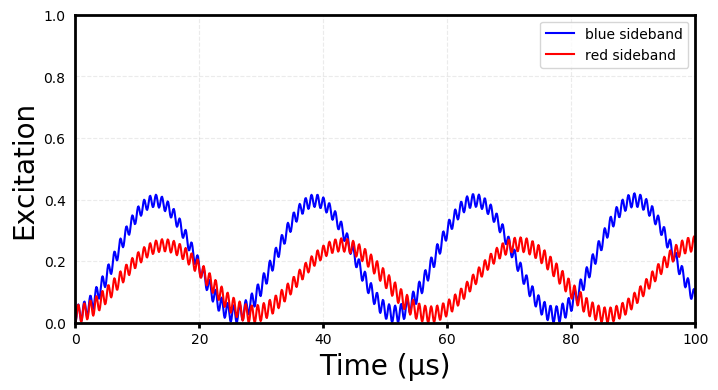

In [43]:
ψ1 = ca["S"] ⊗ mode[1]

# tune laser frequency to blue sideband
detuning!(laser, ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

# tune laser frequency to red sideband
detuning!(laser, -ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

ex_blue = expect(ionprojector(chamber, "D"), sol_blue)
ex_red = expect(ionprojector(chamber, "D"), sol_red)
plt.plot(tout, ex_blue, color="blue", label="blue sideband")
plt.plot(tout, ex_red, color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

The large detuning is coming almost entirely from an AC Stark shift off of the carrier transition.

We can confirm this by using they `rwa_cutoff` keyword in the `hamiltonian` function. Setting `rwa_cutoff=x`, will neglect all terms in the Hamiltonian that oscillate faster than `x`. 

````{margin}
```{note}
This doesn't apply to user-defined time-dependent parameters (described in the next section).
```
````

Since the vibrational mode frequency has been set to 1 MHz, if we set `rwa_cutoff=1e5`, we should neglect the carrier Stark shift in our simulation:

  0.009923 seconds (16.59 k allocations: 935.641 KiB)
  0.009140 seconds (13.23 k allocations: 845.641 KiB)


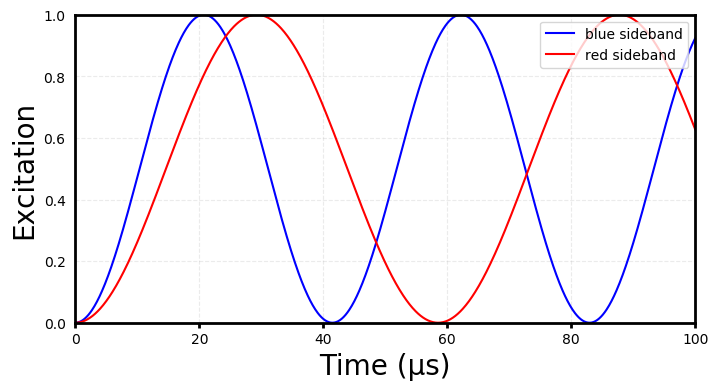

In [44]:
# tune laser frequency to blue sideband
detuning!(laser, ν)

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

# tune laser frequency to red sideband
detuning!(laser, -ν)

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

ex_blue = expect(ionprojector(chamber, "D"), sol_blue)
ex_red = expect(ionprojector(chamber, "D"), sol_red)
plt.plot(tout, ex_blue, color="blue", label="blue sideband")
plt.plot(tout, ex_red, color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

A final note about the `rwa_cutoff`: 
If `hamiltonian` knows that you're not performing an RWA, it can do some optimization to reduce the number of internal functions that need to be evaluated, leading to faster performance. We can let it know that we're not performing an RWA by setting `rwa_cutoff=Inf` (this is the default value).

To reiterate: if you're not performing an RWA, then setting `rwa_cutoff` equal to `Inf`, rather than some arbitrarily large value, will lead to faster performance.

### Time-dependent parameters

All of the parameters denoted as time-dependent in the Hamiltonian equation at the start of this notebook can be set to arbitrary single-valued functions by the user. This can be useful for things like optimal control and modeling noise. 

Below we'll give a couple of examples of this.

First we note that the Stark shift-induced detuning of the BSB Rabi flop in the previous section can be compensated by adding an additional detuning to the laser:

 14.691759 seconds (745.27 k allocations: 19.802 MiB)


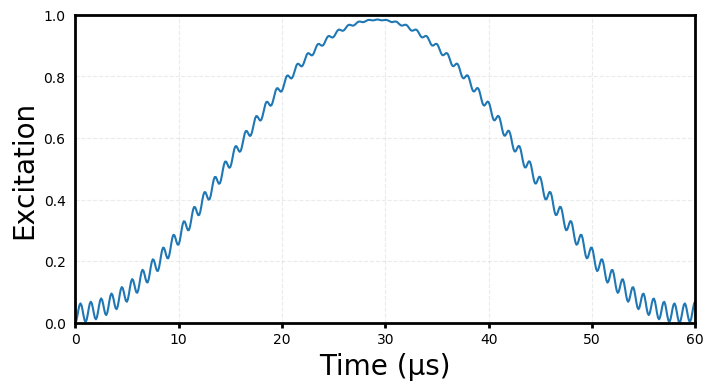

In [45]:
# add additional detuning to BSB to compensate for carrier Stark shift
detuning!(laser, ν-31e3)

tspan = 0:0.1:60
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

However, we're still stuck with the off-resonant population oscillations from the carrier transition. It turns out we can eliminate these by ramping up the amplitude of the laser at the beginning of the simulation.

Such a ramp can be set with the `intensity` of the laser:

In [46]:
# get previous value of intensity field strength
I = intensity_from_pitime(1, 2e-6, 1, ("S", "D"), chamber) 

# Simple amplitude ramping function
function Ω_4us(t)
    if t < 4
        return sin(2π * t / 16)^2
    else
        return 1
    end
end

intensity!(laser, t -> I*Ω_4us(t)^2);

 30.452336 seconds (1.38 M allocations: 32.742 MiB, 0.22% compilation time)


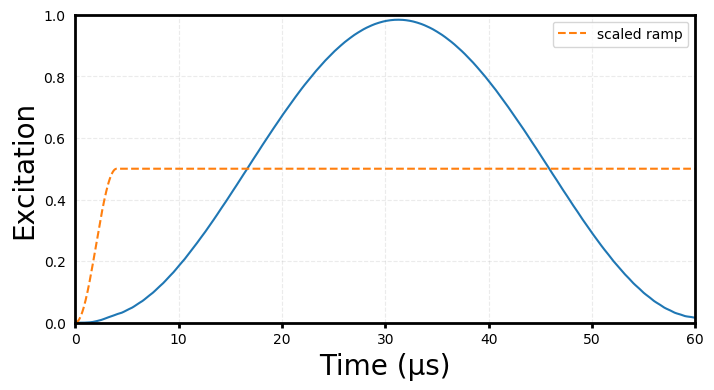

In [47]:
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.plot(tout, @.(Ω_4us(tout)/2), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

To be a bit more succinct we can use a Julia *anonymous function*:

In [48]:
# To make things interesting let's also reduce the ramp time from 4 μs to 1 μs
Ω_1us = t -> t < 1 ? sin(2π * t / 4)^2 : 1
intensity!(laser, t -> I*Ω_1us(t)^2);

 43.024349 seconds (1.52 M allocations: 35.659 MiB, 3.81% compilation time)


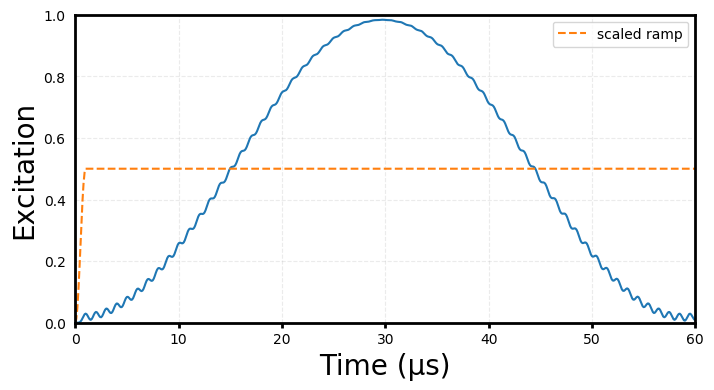

In [49]:
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
plt.plot(tout, ex)
plt.plot(tout, @.(Ω_1us(tout)/2), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

Even with just a 1 μs ramp, we already see noticeable reduction of the fast oscillations.

As an applied example of a time-dependent laser frequency, we can simulate Rapid Adiabatic Passage or RAP {cite:p}`rap`, which can be used for robust preparation of the ion in an excited state.

---
We'll linearly sweep through the laser's frequency from -150 kHz to +150 kHz detuned from the carrier transition
in a time `Tp`

In [50]:
# the length of time of the frequency chirp in μs
Tp = 150

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * 150e-3

# Set the frequency chirp
phase!(laser, t -> (-Δϕ + (2Δϕ / Tp) * t) * t);

We'll also ramp the Rabi frequency: 

````{margin}
```{note}
Note I wasn't able to match the results from the paper when using a Gaussian profile, as they
as described in the referenced paper, so instead I use a sin^2 profile.
```
````

In [51]:
I = intensity_from_pitime(1, 6.5e-6, 1, ("S", "D"), chamber)
tr = 33
function Ω(t)
    if t < tr
        return sin(2π * t / 4tr)^2
    elseif tr <= t <= 150 - tr
        return 1
    elseif 150 - tr < t < 150
        return sin(2π * (t - 150) / 4tr)^2
    else
        return 0
    end
end

intensity!(laser, t -> I*Ω(t)^2);

127.910394 seconds (3.56 M allocations: 71.396 MiB, 9.63% compilation time)


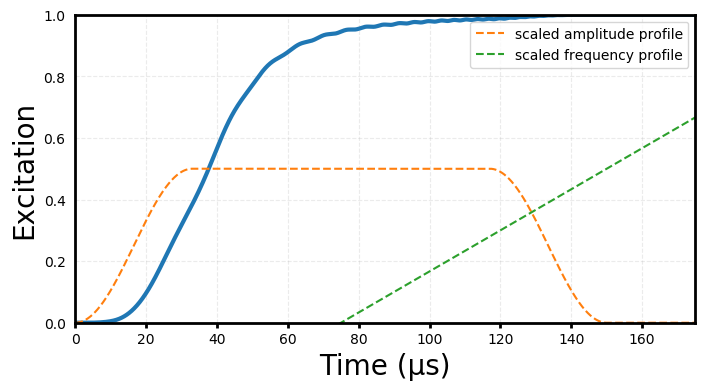

In [52]:
# Set the B-field to match the value in the reference
bfield!(chamber, 2.9e-4)

# set detuning back to carrier at new magnetic field
wavelength_from_transition!(laser, ca, ("S", "D"), chamber);
detuning!(laser, 0)

tspan = 0:0.1:175
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
ϕ = phase(laser)
plt.plot(tout, ex, lw=3)
plt.plot(
        tout, @.(Ω(tout)/2), 
        linestyle="--", label="scaled amplitude profile"
    )
plt.plot(
        tout, @.(ϕ(tout) / (2Δϕ * tout)), 
        linestyle="--", label="scaled frequency profile"
    )
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

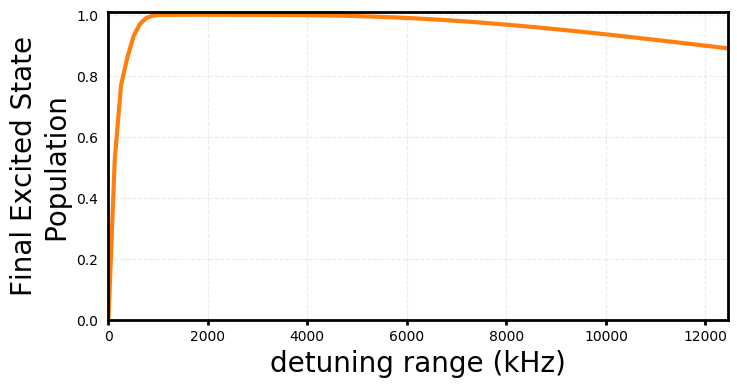

In [53]:
detuning_range = 2π*1e-6 .* collect(1e3:2e4:2e6)
pops = Vector{Float64}(undef, 0)
for Δϕ in detuning_range
    phase!(laser, t -> (-Δϕ/2 + (Δϕ / Tp) * t) * t)
    h = hamiltonian(chamber, timescale=1e-6)
    _, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)
    push!(pops, real(expect(ionprojector(chamber, "D"), sol)[end]))
end
plt.plot(@.(detuning_range * 1e3), pops, lw=3, color="C1")
plt.xlim(-10, detuning_range[end] * 1e3)
plt.ylim(0, 1.01)
plt.ylabel("Final Excited State\nPopulation")
plt.xlabel("detuning range (kHz)");

In [54]:
# get rid of frequency chirp
phase!(laser, 0);

### Noise (in progress)

QuantumOptics has several solvers that can incorporate noise. Here are some examples for using these with IonSim. 

First we'll consider decoherence of the state $|\psi\rangle = |S\rangle + |D\rangle$ due to B-field fluctuations, which can be implemented by setting `T.δB` which has units of Tesla (we won't do it here, but this value can also be made time-dependent). 

In [55]:
# using StochasticDiffEq

In [56]:
# tspan = collect(0:10.:30000)
# β = 1e-2
# σ = √(2β)
# w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
# w.dt = 0.1;

In [57]:
# plt.title("O-U noise")
# warray = [w(t)[1] for t in tspan]
# plt.plot(tspan, warray)
# plt.show()

In [58]:
# using DSP: periodogram

In [59]:
# sample_rate = (length(tspan) - 1)/tspan[end]
# pwarray = periodogram(warray, fs=sample_rate)
# freqs = pwarray.freq
# abs_freqs = freqs .* 1e6
# powers = pwarray.power
# N = 50
# for i in 1:N-1
#     w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
#     w.dt = 0.1
#     warray = [w(t)[1] for t in tspan]
#     powers .+= periodogram(warray, fs=sample_rate).power
# end
# powers ./= powers[2]

# plt.loglog(abs_freqs, powers, label="numerical")
# ou_psd(f) = σ^2 / (β^2 + (2π * f)^2)
# plt.loglog(abs_freqs, ou_psd.(freqs) ./ ou_psd(freqs[2]), color="C1", label="theoretical", ls="--")
# plt.ylabel("relative power")
# plt.xlabel("frequency [Hz]")
# plt.title("O-U PSD")
# plt.ylim(10e-3, 2)
# plt.xlim(250, 2e4)
# plt.legend()
# plt.show()

In [60]:
# # Let's create a new Ion with the right energy sublevels for a Δm = 2 transition
# C = Ca40([("S1/2", -1/2), ("D5/2", -5/2)])
# set_sublevel_alias!(C, Dict("S" => ("S1/2", -1/2),
#                             "D" => ("D5/2", -5/2)))

# # Create a new Trap with the new Ion
# chain = LinearChain(
#         ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
#         vibrational_modes=(;z=[1]))

# T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

# # Redefine mode for new trap
# mode = T.configuration.vibrational_modes.z[1];

# # Display sublevels of new ion
# sublevels(T.configuration.ions[1])

In [61]:
# # we're not paying attention to the vibrational mode here, so we set its dimension to 1,
# # effectively ignoring it
# mode.N = 1

# # construct a zero operator
# L.E = 0
# T.δB = 0.1
# h = hamiltonian(T)

# # construct noise operator
# T.δB = 5e-1
# hs = hamiltonian(T)
# hsvec = (t, ψ) -> [hs(t, ψ)]

# ψi_ion = (C["S"] + C["D"])/√2
# ψi = ψi_ion ⊗ mode[0]

# Ntraj = 100
# ex = zero(tspan)

# # iterate SDE solver Ntraj times and average results
# w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
# for i in 1:Ntraj
#     if mod(i,10) == 1
#         println(i)
#     end
#     tout, sol = stochastic.schroedinger_dynamic(tspan, ψi, h, hsvec, noise=w,
#     normalize_state=true, dt=0.1)
#     ex .+= real.(expect(dm(ψi_ion) ⊗ one(mode), sol)) ./ Ntraj
# end

# plt.plot(tspan, ex, color="C0", label="Simulated Contrast")
# plt.xlim(tspan[1], tspan[end])
# plt.ylim(0, 1)
# plt.legend()
# plt.ylabel("Ramsey Signal")
# plt.xlabel("Time (μs)")
# plt.show()

We can compare the same magnitude of B-field fluctuations for a white PSD. We could use the stochastic solver again, but instead let's use a Lindblad master equation solver:

In [62]:
# γ1 = hs(1.0, 0).data[1, 1]/40
# γ2 = hs(1.0, 0).data[2, 2]/40

# rates = 1/4π .* abs.([γ1, γ2])

# hs1 = C["S"] ⊗ C["S"]' ⊗ one(mode)
# hs2 = C["D"] ⊗ C["D"]' ⊗ one(mode)

# tspan = collect(0:1.:30000)
# @time tout, sol = timeevolution.master(tspan, dm(ψi), h(1.0, 0.0), [hs1, hs2], rates=rates, maxiters=1e8)

# ex = expect(dm(ψi_ion) ⊗ one(mode), sol)
# plt.plot(tspan, ex)
# plt.xlim(tspan[1], tspan[end])
# plt.ylim(0, 1)
# plt.ylabel("Ramsey Contrast")
# plt.xlabel("Time (μs)")
# plt.show()

A brute force way to include shot-to-shot noise on a simulated parameter is to just run the simulation multiple times -- with the parameter pulled each time from some probability distribution -- and then average the results.

As an example, we consider fluctuations of the laser's electric field $E$ such that  $E \sim \mathcal{N}(\bar{E}, \delta E^2)$, then we should expect a Gaussian decay profile $e^{-t^2 / 2\tau^2}$ with: $1/\tau = \delta E\bigg(\frac{\partial\omega}{\partial E}\bigg)$.

In [63]:
# # Move back to using Δm = 0 transition
# C = Ca40([("S1/2", -1/2), ("D5/2", -1/2)])
# set_sublevel_alias!(C, Dict("S" => ("S1/2", -1/2),
#                             "D" => ("D5/2", -1/2)))

# chain = LinearChain(
#         ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
#         vibrational_modes=(;z=[1]))

# T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

# mode = T.configuration.vibrational_modes.z[1];

In [64]:
# T.B = 4e-4
# T.δB = 0

# # recompute the wavelength
# L.λ = transitionwavelength(C, ("S", "D"), T);

# E = Efield_from_pi_time(2e-6, T, 1, 1, ("S", "D"))
# tspan = 0:0.1:60

# # average over Ntraj runs
# Ntraj = 1000
# δE = 0.025E
# ex = zero(tspan)
# ψi = C["S"] ⊗ mode[0]
# @time begin
#     for i in 1:Ntraj
#         ΔE = δE * randn()
#         L.E = E + ΔE 
#         h = hamiltonian(T)
#         tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h)
#         ex .+= expect(ionprojector(T, "D"), sol) ./ Ntraj
#     end
# end

# # compute expected τ
# hz_per_E = 1 / Efield_from_rabi_frequency(1, ẑ, L, C, ("S", "D"))
# τ_us = 1e6 / (2π * δE * hz_per_E)

# plt.plot(tspan, ex)
# plt.plot(
#         tspan, @.((1 + exp(-(tspan / (√2 * τ_us))^2))/2), 
#         color="C1", ls="--", label="Gaussian Envelope"
#     )
# plt.plot(
#         tspan, @.((1 - exp(-(tspan / (√2 * τ_us))^2))/2), 
#         color="C1", ls="--"
#     )
# plt.xlim(tspan[1], tspan[end])
# plt.ylim(0, 1)
# plt.legend()
# plt.ylabel("Excitation")
# plt.xlabel("Time (μs)");

### Adding more than a single ion/laser

Adding addtional lasers and ions to the system is straightforward. Here we'll see how that's done by modeling a Mølmer-Sørensen interaction {cite:p}`PhysRevA.62.022311`, which can be used to entangle the electronic states of multiple ions and requires at least two laser tones and vibrational mode.

In [65]:
# Construct the system
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
laser1 = Laser()
laser2 = Laser()
chain = LinearChain(
        ions=[ca, ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/neil/.julia/dev/IonSim/src/iontraps.jl:166


In [66]:
# Set the laser parameters
ϵ = 40e3
d = 80  # corrects for AC stark shift from single-photon coupling to sidebands
mode = zmodes(chamber)[1]
ν = frequency(mode)

wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
detuning!(laser1, ν + ϵ - d)
polarization!(laser1, x̂)
wavevector!(laser1, ẑ)

wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)
detuning!(laser2, -ν - ϵ + d)
polarization!(laser2, x̂)
wavevector!(laser2, ẑ)

modecutoff!(mode, 5)

η = abs(lambdicke(mode, ca, laser1))
Ω1 = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ
intensity_from_rabifrequency!(1, Ω1, 1, ("S", "D"), chamber)
intensity_from_rabifrequency!(2, Ω1, 1, ("S", "D"), chamber);

In [67]:
ψi = ca["S"] ⊗ ca["S"] ⊗ mode[0];  # initial state

 36.859962 seconds (12.31 M allocations: 1.075 GiB, 4.77% gc time, 3.47% compilation time)


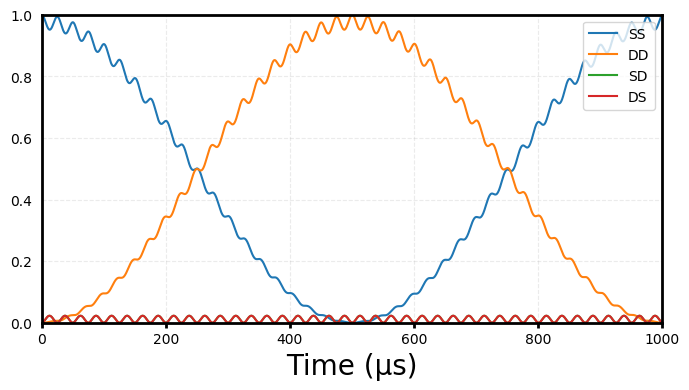

In [68]:
# setup and run the Hamiltonian
h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=5e5)
tspan = 0:0.25:1000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

SS = expect(ionprojector(chamber, "S", "S"), sol)
DD = expect(ionprojector(chamber, "D", "D"), sol)
SD = expect(ionprojector(chamber, "S", "D"), sol)
DS = expect(ionprojector(chamber, "D", "S"), sol)
plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

We can compare this to the analytical result:

In [69]:
?analytical.molmersorensen2ion

```
molmersorensen2ion(tspan, Ω::Real, ν::Real, δ::Real, η::Real, n̄::Real)
```

[ref](https://doi.org/10.1103/PhysRevA.62.022311) <br> Assumes vibrational mode starts in a thermal state with: $\langle a^\dagger a\rangle = n̄$  and ions start in doubly ground state. Returns `(ρgg, ρee)`, the population in the doubly  ground and doubly excited state, respectively. $[Ω], [ν], [δ] = Hz$


````{toggle}
```
molmersorensen2ion(tspan, Ω::Real, ν::Real, δ::Real, η::Real, n̄::Real)
```
[ref](https://doi.org/10.1103/PhysRevA.62.022311)

Assumes vibrational mode starts in a thermal state with: $\langle a^\dagger a\rangle = n̄$ 
and ions start in doubly ground state. Returns `(ρgg, ρee)`, the population in the doubly 
ground and doubly excited state, respectively. ``[Ω], [ν], [δ] = Hz``
````

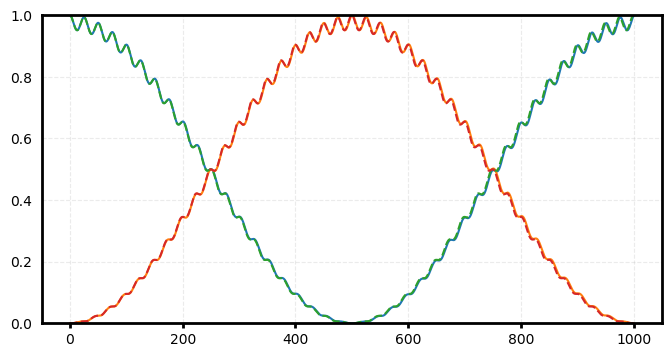

In [70]:
ex = analytical.molmersorensen2ion(tspan, 1e-6Ω1, 1e-6ν, 1e-6ν + 1e-6ϵ, η, 0)
plt.plot(tspan, SS)
plt.plot(tspan, DD)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.ylim(0, 1);

We can also see what happens when the vibrational mode starts out in a thermal state:

 48.651787 seconds (14.40 M allocations: 1.388 GiB, 6.77% gc time, 1.51% compilation time)


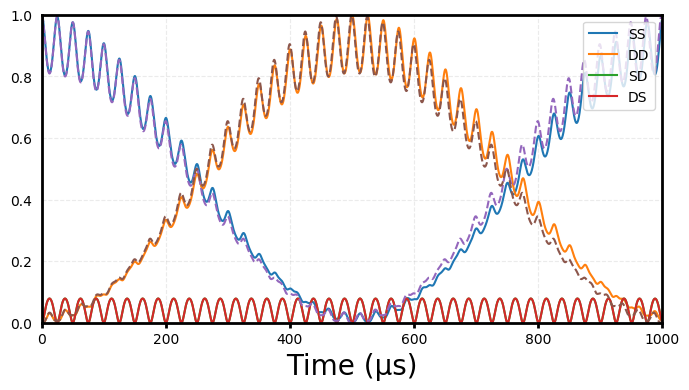

In [71]:
modecutoff!(mode, 15)
ρi = dm(ionstate(chamber, ["S", "S"])) ⊗ thermalstate(mode, 2)  # thermal state
h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=5e5)
tspan = collect(0:0.25:1000)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ρi, h)

SS = expect(ionprojector(chamber, "S", "S"), sol)
DD = expect(ionprojector(chamber, "D", "D"), sol)
SD = expect(ionprojector(chamber, "S", "D"), sol)
DS = expect(ionprojector(chamber, "D", "S"), sol)
plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")
ex = analytical.molmersorensen2ion(tspan, 1e-6Ω1, 1e-6ν, 1e-6ν + 1e-6ϵ, η, 2)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

There is some discrepancy because of the Lamb-Dicke approximation made in the analytical solution.

Adding more ions/lasers/modes is done in the same way.

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/neil/.julia/dev/IonSim/src/iontraps.jl:166


 22.104712 seconds (18.30 M allocations: 1.273 GiB, 2.82% gc time, 2.77% compilation time)


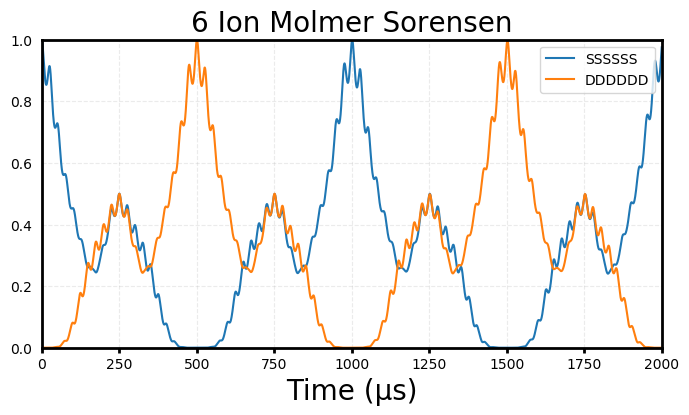

In [72]:
chain = LinearChain(
        ions=[ca, ca, ca, ca, ca, ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2])
globalbeam!(laser1, chamber)  # set laser1 to shine equally on all ions
globalbeam!(laser2, chamber)  # set laser2 to shine equally on all ions
mode = zmodes(chamber)[1]
modecutoff!(mode, 5)
η = abs(lambdicke(mode, ca, laser1))
Ω2 = √(1e3 * ϵ) / η  
intensity_from_rabifrequency!(1, Ω2, 1, ("S", "D"), chamber)
intensity_from_rabifrequency!(2, Ω2, 1, ("S", "D"), chamber)
ψi = ionstate(chamber, repeat(["S"], 6)) ⊗ mode[0]

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=5e5)
tspan = 0:0.25:2000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

S = expect(ionprojector(chamber, repeat(["S"], 6)...), sol)
D = expect(ionprojector(chamber, repeat(["D"], 6)...), sol)
plt.plot(tout, S, label="SSSSSS")
plt.plot(tout, D, label="DDDDDD")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.title("6 Ion Molmer Sorensen")
plt.xlabel("Time (μs)");

## IonSim.PhysicalConstants

You can find some commonly used physical constants in `IonSim.PhysicalConstants`. They support all normal algebraic operations.

In [73]:
const pc = IonSim.PhysicalConstants;

In [74]:
pc.ħ

1.0545718e-34 [m²kg/s]

In [75]:
pc.c

2.99792458e8 [m/s]

In [76]:
println(pc.μB / pc.ħ)
println(pc.ħ + pc.c)
println(pc.α^pc.α)

8.794100069810324e10
2.99792458e8
0.9647321772836126


## Bibliography

```{bibliography} getting_started.bib
:filter: docname in docnames
```